In [1]:
import os
os.chdir('../src')
import numpy as np
np.set_printoptions(precision=2)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from directed_gradient import DirectedGradient
from test_optims import directed_step
import test_fn as test_fn
from terminaltables import DoubleTable as Table
import torch as t

In [8]:
dim = 2
g_std = 0.0

num_epochs = 10
log_int=1
final_table = True

visualize = dim == 2
xlim = 3.0
xc = 2

ylim = 3.0
yc = 2
delta = 0.25

- high sensitivity to learning rate for CGD

In [12]:
lr = {
    'booth': 1e-2,
    'himmelblau': 1e-3,
    'square': 1e-1,
    'rastrigin': 1e-4,
    'rosenbrock': 1e-4,
}


init = {
    'booth': 4.5,
    'himmelblau': 4.5,
    'square': 4.5,
    'rastrigin': 1.5,
    'rosenbrock': 2.0,
}

fn = {
    'booth': test_fn.booth,
    'himmelblau': test_fn.himmelblau,
    'square': test_fn.square,
    'rastrigin': test_fn.rastrigin,
    'rosenbrock': test_fn.rosenbrock
}

In [13]:
tmp = [t.tensor([2, 2], dtype=t.float)]
table = [['func', 'output']]
for _, f in fn.items():
    table.append([_, '{:.8}'.format(f(tmp).item())])
table = Table(table, 'Test')
print(table.table)

╔Test════════╦═══════════╗
║ func       ║ output    ║
╠════════════╬═══════════╣
║ booth      ║ 2.0       ║
║ himmelblau ║ 26.0      ║
║ square     ║ 7.9999995 ║
║ rastrigin  ║ 8.0       ║
║ rosenbrock ║ 401.0     ║
╚════════════╩═══════════╝


--------------------------------------------------------------------------------
Noise Added:  0.0
--------------------------------------------------------------------------------


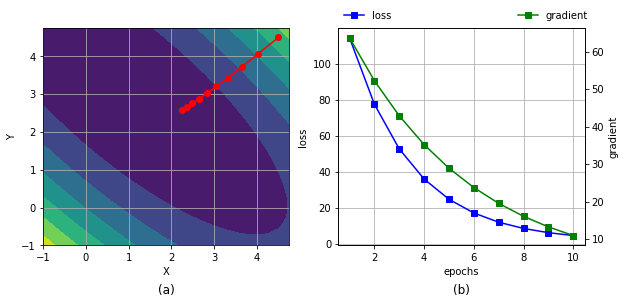

╔booth═════════════╦═════════════╦═════════════╦═════════════╦══════════╗
║ ep ║ pt          ║ g_1         ║ g_2         ║ g           ║ fn_val   ║
╠════╬═════════════╬═════════════╬═════════════╬═════════════╬══════════╣
║ 10 ║ [2.25 2.59] ║ [9.21 0.  ] ║ [0.   5.88] ║ [9.21 5.88] ║ 4.551107 ║
╚════╩═════════════╩═════════════╩═════════════╩═════════════╩══════════╝


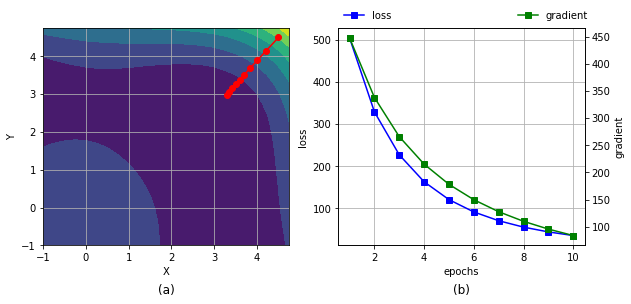

╔himmelblau════════╦═══════════════╦═══════════════╦═══════════════╦═══════════╗
║ ep ║ pt          ║ g_1           ║ g_2           ║ g             ║ fn_val    ║
╠════╬═════════════╬═══════════════╬═══════════════╬═══════════════╬═══════════╣
║ 10 ║ [3.3  2.99] ║ [48.56  0.  ] ║ [ 0.   68.46] ║ [48.56 68.46] ║ 35.788654 ║
╚════╩═════════════╩═══════════════╩═══════════════╩═══════════════╩═══════════╝


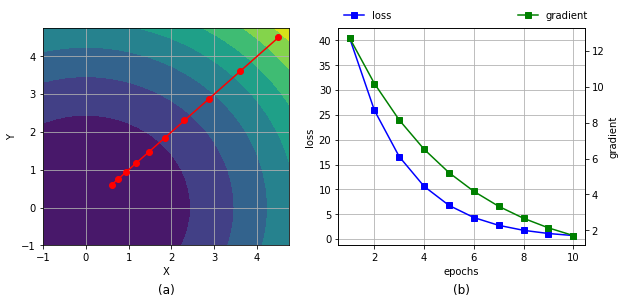

╔square══════════╦═════════════╦═════════════╦═════════════╦══════════╗
║ ep ║ pt        ║ g_1         ║ g_2         ║ g           ║ fn_val   ║
╠════╬═══════════╬═════════════╬═════════════╬═════════════╬══════════╣
║ 10 ║ [0.6 0.6] ║ [1.21 0.  ] ║ [0.   1.21] ║ [1.21 1.21] ║ 0.729583 ║
╚════╩═══════════╩═════════════╩═════════════╩═════════════╩══════════╝


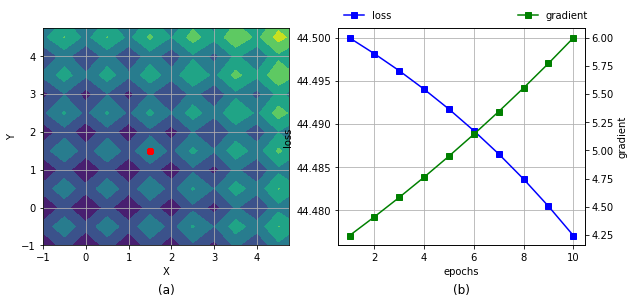

╔rastrigin═══════╦═════════════╦═════════════╦═════════════╦═══════════╗
║ ep ║ pt        ║ g_1         ║ g_2         ║ g           ║ fn_val    ║
╠════╬═══════════╬═════════════╬═════════════╬═════════════╬═══════════╣
║ 10 ║ [1.5 1.5] ║ [4.24 0.  ] ║ [0.   4.24] ║ [4.24 4.24] ║ 44.477074 ║
╚════╩═══════════╩═════════════╩═════════════╩═════════════╩═══════════╝


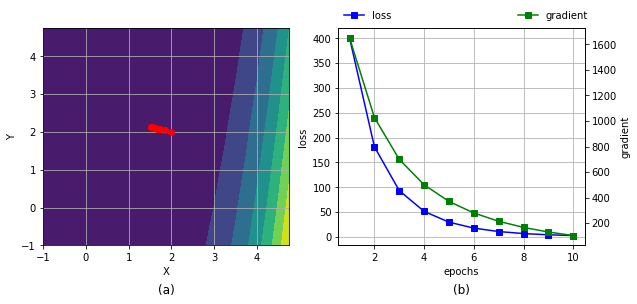

╔rosenbrock════════╦═══════════════╦═════════════════╦═════════════════╦══════════╗
║ ep ║ pt          ║ g_1           ║ g_2             ║ g               ║ fn_val   ║
╠════╬═════════════╬═══════════════╬═════════════════╬═════════════════╬══════════╣
║ 10 ║ [1.51 2.14] ║ [97.64  0.  ] ║ [ -0.   -31.89] ║ [ 97.64 -31.89] ║ 2.807416 ║
╚════╩═════════════╩═══════════════╩═════════════════╩═════════════════╩══════════╝


In [14]:
sdirs = [t.tensor([1, 0], dtype=t.float), t.tensor([0, 1], dtype=t.float)]
eut = 1

print('-'*80)
print("Noise Added: ", g_std)
print('-'*80)
for fn_name in lr:
    params = [[t.tensor([init[fn_name] for _ in range(dim)], dtype=t.float, requires_grad=True)],
              [t.tensor([init[fn_name] for _ in range(dim)], dtype=t.float, requires_grad=True)]]

    table = [['ep', 'pt', 'g_1', 'g_2', 'g', 'fn_val']]
    for epoch in range(num_epochs):
        loss = [fn[fn_name](params[0]),
                fn[fn_name](params[1])]
        opt = [DirectedGradient(params[0], lr=lr[fn_name]),
               DirectedGradient(params[1], lr=lr[fn_name])]
        opt[0].zero_grad()
        opt[1].zero_grad()
        loss[0].backward()
        loss[1].backward()
        for idx, sdir in enumerate(sdirs):
            directed_step(
                params[idx], 
                [sdir], opt[idx], lr[fn_name], g_std
            )
        g = params[0][0].grad + params[1][0].grad
        g_0 = params[0][0].grad.clone()
        g_1 = params[1][0].grad.clone()
        params[0][0].grad = g.clone()
        params[1][0].grad = g.clone()
        if (epoch+1)%log_int == 0:
            table.append([
                epoch+1,
                params[0][0].clone().detach().numpy(), g_0.numpy(), g_1.numpy(), g.numpy(), 
                '{:.6f}'.format(loss[0].item()/2 + loss[1].item()/2)
            ])
        opt[0].step(lr[fn_name])
        opt[1].step(lr[fn_name])
        p = params[0][0].detach().clone()/2 + params[1][0].detach().clone()/2
        if epoch % eut == 0:
            params[0][0] = p.clone()
            params[0][0].requires_grad = True
            params[1][0] = p.clone()
            params[1][0].requires_grad = True

    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = ax2.twinx()

    x = np.arange(xc-xlim, xc+xlim, delta)
    y = np.arange(yc-ylim, yc+ylim, delta)
    X, Y = np.meshgrid(x, y)
    size = X.shape
    Z = np.array([fn[fn_name]([t.tensor(_)]).item() for _ in zip(X.flatten(), Y.flatten())]).reshape(size)
    CS = ax1.contourf(X, Y, Z)
    ax1.set_title('(a)', y=-0.25)
    x, x0, x1, y, y0, y1 = [], [], [], [], [], []
    for row in table[1:]:
        pt0 = row[1]
        x0.append(pt0[0].item())
        y0.append(pt0[1].item())
    ax1.plot(x0, y0, 'ro-')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.grid()


    data = [(_[0], t.norm(t.tensor(_[-2])).item(), float(_[-1])) for _ in table[1:]]
    x, y2, y1 = zip(*data)
    ax2.plot(x, y1, 'bs-', label='loss')
    ax3.plot(x, y2, 'gs-', label='gradient')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('loss')
    ax3.set_ylabel('gradient')
    ax2.set_title('(b)', y=-0.25)
    ax2.grid()
    ax2.legend(loc='upper right', bbox_to_anchor=(-1, 1.1, 1.25, 0.02), frameon=False)
    ax3.legend(loc='upper right', bbox_to_anchor=(-0.2, 1.1, 1.25, 0.02), frameon=False)
    plt.show()

    if final_table:
        table = [table[0], table[-1]]
    table = Table(table, fn_name)
    table.justify_columns[0] = 'right'
    print(table.table)
    